# Generate Realistic Human Face using GAN

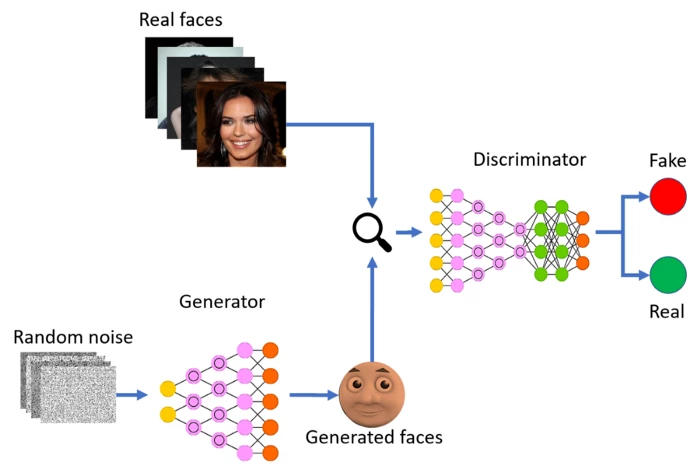

### Why were GANs developed in the first place?

It has been noticed most of the mainstream neural nets can be easily fooled into misclassifying things by adding only a small amount of noise into the original data. Surprisingly, the model after adding noise has higher confidence in the wrong prediction than when it predicted correctly. The reason for such an adversary is that most machine learning models learn from a limited amount of data, which is a huge drawback, as it is prone to overfitting. Also, the mapping between the input and the output is almost linear. Although it may seem that the boundaries of separation between the various classes are linear, in reality, they are composed of linearities and even a small change in a point in the feature space might lead to misclassification of data.

### How does GANs work?

**GANs** learn a probability distribution of a dataset by pitting two neural networks against each other.


One neural network, called the **Generator**, generates new data instances, while the other, the **Discriminator**, evaluates them for authenticity; i.e. the discriminator decides whether each instance of data that it reviews belongs to the actual training dataset or not.


Meanwhile, the generator is creating new, synthetic/fake images that it passes to the discriminator. It does so in the hopes that they, too, will be deemed authentic, even though they are fake. The fake image is generated from a 100-dimensional noise (uniform distribution between -1.0 to 1.0) using the inverse of convolution, called transposed convolution.


The goal of the generator is to generate passable images: to lie without being caught. The goal of the discriminator is to identify images coming from the generator as fake.


Here are the steps a GAN takes:

1. The generator takes in random numbers and returns an image.

2. This generated image is fed into the discriminator alongside a stream of images taken from the actual, ground-truth dataset.

3. The discriminator takes in both real and fake images and returns probabilities, a number between 0 and 1, with 1 representing a prediction of authenticity and 0 representing fake.

So you have a double feedback loop:

1. The discriminator is in a feedback loop with the ground truth of the images, which we know.

2. The generator is in a feedback loop with the discriminator.

You can read the full blog on [www.theaidream.com](https://www.theaidream.com/post/generate-realistic-human-face-using-gan-1)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

from matplotlib import pyplot as plt

from tqdm import tqdm
from PIL import Image as Img
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop


Using TensorFlow backend.


### Load the data and resize the iamges

In [2]:
from PIL import Image

In [3]:
#
PIC_DIR = f'D:/datathon 2022 dataset/Data_Split - Mp vs Others/train/Moneypox/'

IMAGES_COUNT = 10000

ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2

WIDTH = 128
HEIGHT = 128

crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open(PIC_DIR + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
    images.append(np.uint8(pic))

100%|███████████████████████████████████████████████████████████████████████████████| 489/489 [00:00<00:00, 679.16it/s]


In [4]:
#Image shape
images = np.array(images) / 255
print(images.shape)

(489, 128, 128, 3)


### Display first 25 images

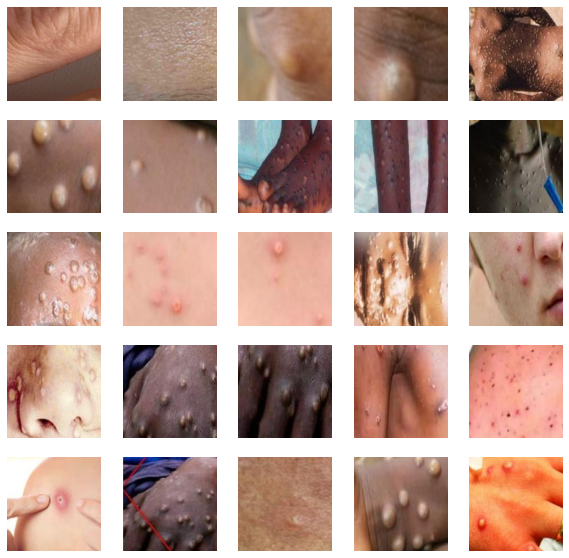

In [5]:
#Display first 25 images
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

### The next step is to create a Generator

The generator goes the other way: It is the artist who is trying to fool the discriminator. This network consists of 8 convolutional layers. Here first, we take our input, called gen_input and feed it into our first convolutional layer. Each convolutional layer performs a convolution and then performs batch normalization and a leaky ReLu as well. Then, we return the tanh activation function.

In [6]:
LATENT_DIM = 32
CHANNELS = 3

def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator

### Next, create a Discriminator

The discriminator network consists of convolutional layers the same as the generator. For every layer of the network, we are going to perform a convolution, then we are going to perform batch normalization to make the network faster and more accurate and finally, we are going to perform a Leaky ReLu.

In [7]:
def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator

### Define a GAN Model

Next, a GAN model can be defined that combines both the generator model and the discriminator model into one larger model. This larger model will be used to train the model weights in the generator, using the output and error calculated by the discriminator model. The discriminator model is trained separately, and as such, the model weights are marked as not trainable in this larger GAN model to ensure that only the weights of the generator model are updated. This change to the trainability of the discriminator weights only affects when training the combined GAN model, not when training the discriminator standalone.

This larger GAN model takes as input a point in the latent space, uses the generator model to generate an image, which is fed as input to the discriminator model, then output or classified as real or fake.

Since the output of the Discriminator is sigmoid, we use binary cross-entropy for the loss. RMSProp as an optimizer generates more realistic fake images compared to Adam for this case. The learning rate is 0.0001. Weight decay and clip value stabilize learning during the latter part of the training. You have to adjust the decay if you want to adjust the learning rate.

GANs try to replicate a probability distribution. Therefore, we should use loss functions that reflect the distance between the distribution of the data generated by the GAN and the distribution of the real data.

In [8]:
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot

In [9]:
generator = create_generator()
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       1048

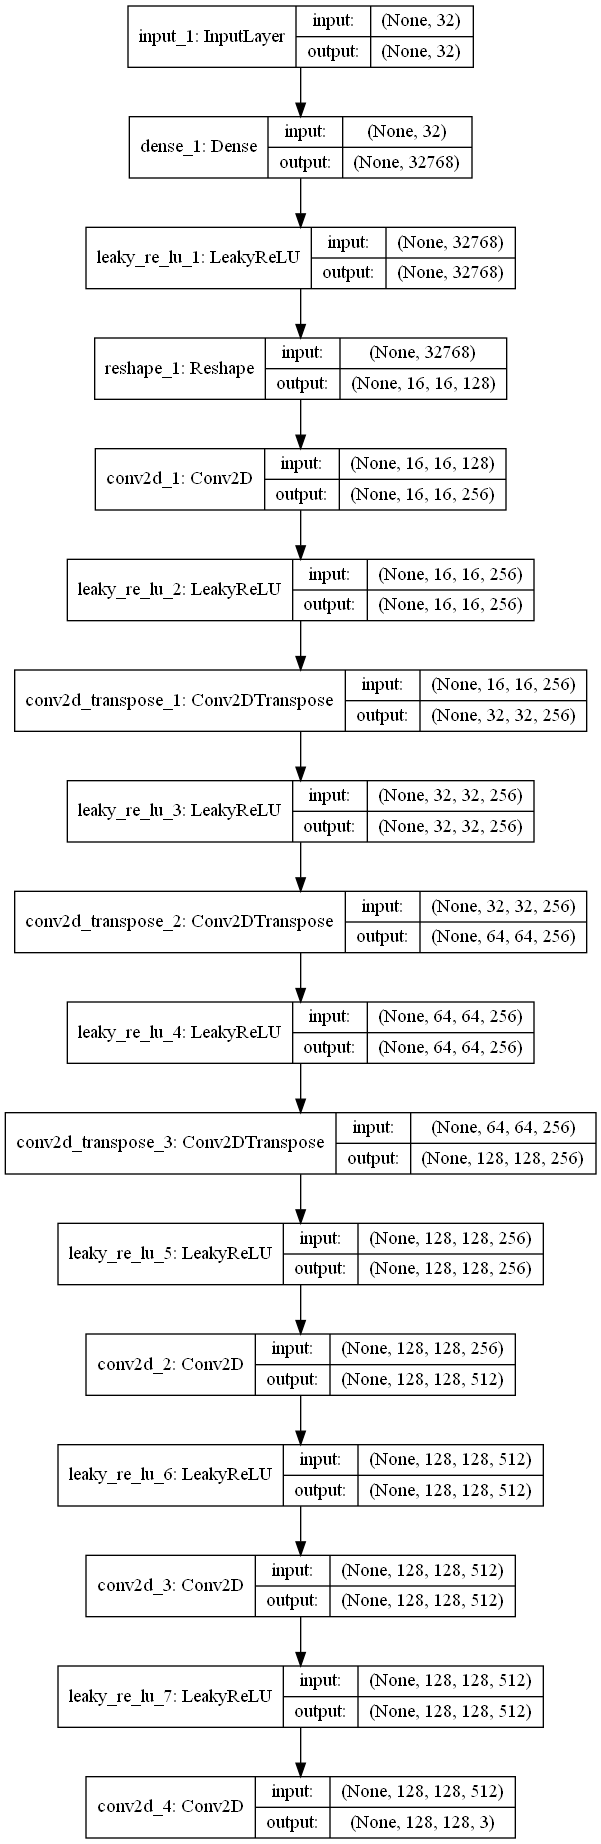

In [10]:
Image(model_to_dot(generator, show_shapes=True).create_png())

In [11]:
discriminator = create_discriminator()
discriminator.trainable = False
discriminator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 126, 126, 256)     7168      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 126, 126, 256)     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 62, 62, 256)       1048832   
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 62, 62, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 256)       1048832   
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 30, 30, 256)       0   

C:\Users\Vipooshan\anaconda3\envs\GPU\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


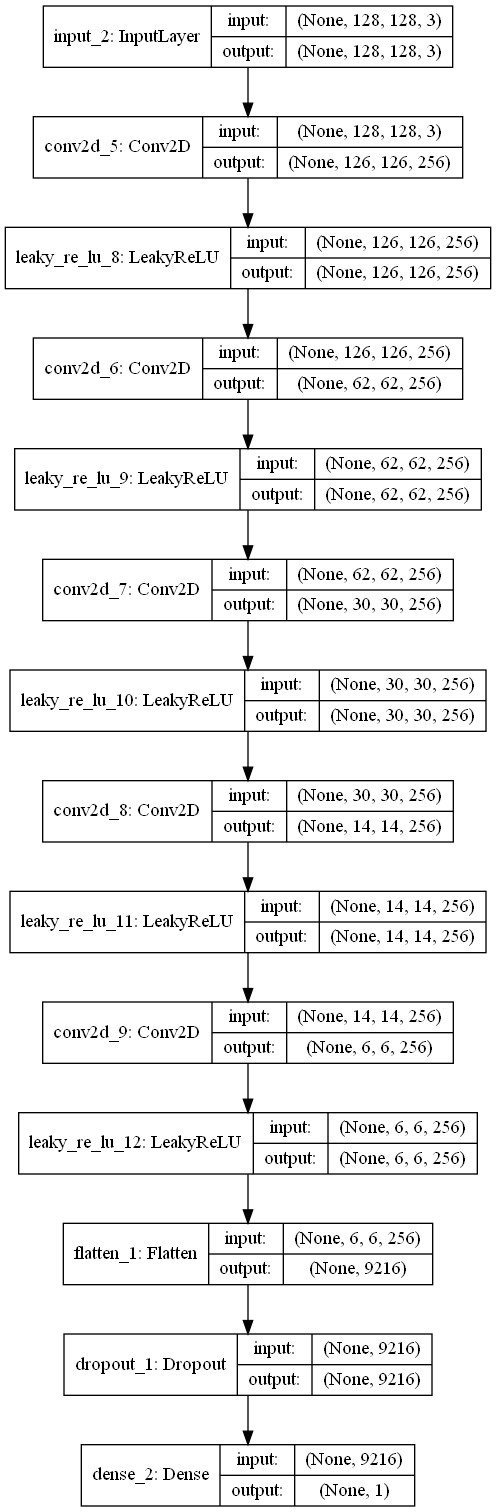

In [13]:
Image(model_to_dot(discriminator, show_shapes=True).create_png())

In [14]:
gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

In [15]:
optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

In [16]:
gan.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32)                0         
_________________________________________________________________
model_1 (Model)              (None, 128, 128, 3)       14953987  
_________________________________________________________________
model_2 (Model)              (None, 1)                 4211713   
Total params: 19,165,700
Trainable params: 14,953,987
Non-trainable params: 4,211,713
_________________________________________________________________


### Training the GAN model:


Training is the hardest part and since a GAN contains two separately trained networks, its training algorithm must address two complications:

GANs must juggle two different kinds of training (generator and discriminator).

GAN convergence is hard to identify.

As the generator improves with training, the discriminator performance gets worse because the discriminator can’t easily tell the difference between real and fake. If the generator succeeds perfectly, then the discriminator has a 50% accuracy. In effect, the discriminator flips a coin to make its prediction.


This progression poses a problem for convergence of the GAN as a whole: the discriminator feedback gets less meaningful over time. If the GAN continues training past the point when the discriminator is giving completely random feedback, then the generator starts to train on junk feedback, and its quality may collapse.

In [17]:
49 % 50

49

ERROR! Session/line number was not unique in database. History logging moved to new session 2246


In [ ]:
import time
iters = 15000
batch_size = 16

RES_DIR = 'res2'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)

    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0

    if step % 50 == 49:
        gan.save_weights('/gan.h5')

        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Img.fromarray(np.uint8(control_image * 255))#.save(StringIO(), 'jpeg')
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1


ERROR! Session/line number was not unique in database. History logging moved to new session 2245


C:\Users\Vipooshan\anaconda3\envs\GPU\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Vipooshan\anaconda3\envs\GPU\lib\site-packages\IPython\core\interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-3870a0d8e60b>", line 34, in <module>
    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
  File "C:\Users\Vipooshan\anaconda3\envs\GPU\lib\site-packages\keras\engine\training.py", line 1514, in train_on_batch
    outputs = self.train_function(ins)
  File "C:\Users\Vipooshan\anaconda3\envs\GPU\lib\site-packages\tensorflow_core\python\keras\backend.py", line 3727, in __call__
    outputs = self._graph_fn(*converted_inputs)
  File "C:\Users\Vipooshan\anaconda3\envs\GPU\lib\site-packages\tensorflow_core\python\eager\function.py", line 1551, in __call__
    return self._call_impl(args, kwargs)
  File "C:\Users\Vipooshan\anaconda3\envs\GPU\lib\site-packages\tensorflow_core\python\eager\function.py", line 1591, in _call_impl
    return self._ca

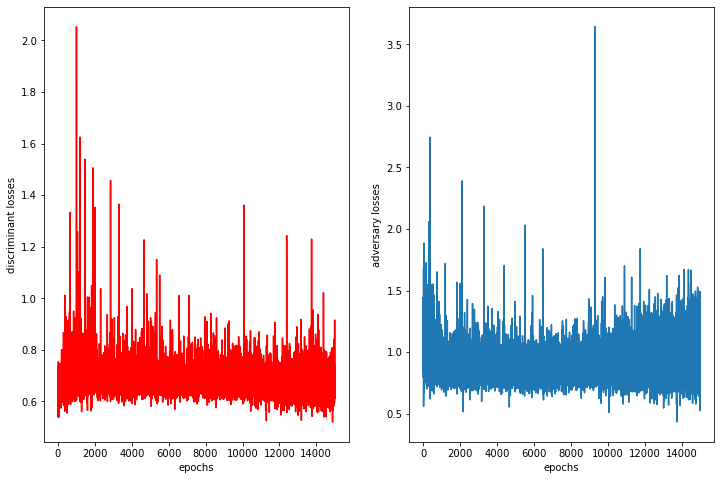

In [41]:
plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses, color='red')
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()

### Let us also make the GIF of the output images that have been generated.

In [ ]:
import imageio
import shutilimages_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))
imageio.mimsave('trainnig_visual.gif', images_to_gif)
shutil.rmtree(RES_DIR)

Check the output here.

https://giphy.com/gifs/QuDO8a4UBfyZrLP331?utm_source=iframe&utm_medium=embed&utm_campaign=Embeds&utm_term=https%3A%2F%2Fwww.kdnuggets.com%2F